In [1]:
import csv
from math import sqrt
import numpy as np
from sklearn.utils import shuffle

class UltrasonicData:
    """ A custom data type: the data member is composed with
    - the distances from the car to the surrounding wall at one or 
      multiple sample time
    - and corresponding control commands of the angular velocity.
    """
    def __init__(self, distance, angular):
        self.distance = distance
        self.angular  = angular
        
        
def csv_read(csv_path, length):
    """ Reading ultrasonic data from csv file
    
    input: 
     - csv_path: the path of the csv file
     - length: the length of time sequence used in the training samples
     - dim: the dimensions of the distance array 
    output: 
     - Return a data list which is represented in UltrasonicData 
       data type.
    """
    
    print("Reading data from %s" % csv_path)
    print("The length of time sequence in this file is %d" % length)
        
    # save time-independent sample and corresponding label with
    # UltrasonicData type
    Data = []
    
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            # a list which saves time-dependent distance data
            dist = [float(line[j+i*18]) for i in range(length) for j in range(16)]
            # use the newest command as label
            agl  = float(line[17+(length-1)*18])
            #[float(line[17+i*18]) for i in range(length)]
            Data.append(UltrasonicData(dist, agl))
    
    print("Now {} data have been saved with custom data type".format(len(Data)))
    
    return shuffle(Data)

def data_generator(Data, batch_size, dim=2, shape=(16,16)):
    """ A python data generator
    input: 
    - Data: a list in which data is saved with custom data type
    - batch_size: the size of data batch we want to return
    - dim: the dimensions of data used for training or validation
    - shape: data repeat operation will be done according to this
             parameter.
    return：
    - yeild a batch of samples and lebel when it is called
    """
    height, width = shape
    while True:
        data_batch = np.random.choice(a=Data, size=batch_size)
        X = []
        Y = []
    
        for i in range(len(data_batch)):
            data = data_batch[i]
            if dim == 1:
                dist = data.distance
            elif dim == 2:
                dist = np.array(data.distance)
                # reshape
                dist = dist.reshape(-1,16)
                
                # repeat coloums and rows according to desired width
                dist = dist.repeat(width//16, axis=0)
                dist = dist.repeat(width//16, axis=1)
                
                # add channel axis for the gray scale image
                dist = dist[np.newaxis, :,:]
                
            else:
                pass
            
            # add batch axis
            X.append(dist)
            Y.append(data.angular)
        
        X = np.array(X)
        Y = np.array(Y)
        
        yield X, Y

# 3. Loss function Selection
In this section, we will select a proper loss function to be used in following experiments.
- The RMSE, R-square score, and training time will be used as metrics to evluate the performance of a variety of loss functions.
- The model structure and random seed will be fixed and K-folod cross validation will be used to ensure the reliability of results.

In [11]:
from keras.models import Model 
from keras.layers import Input, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K

from sklearn.model_selection import KFold
from datetime import datetime
import numpy as np

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def R_SQUARE(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/K.clip(SS_tot,K.epsilon(),None)

# assign customed_objects when loading model
dependencies = {'RMSE': RMSE, 'val_RMSE': RMSE, 
                'R_SQUARE': R_SQUARE, 'val_R_SQUARE': R_SQUARE}

csv_path = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-16.csv"

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/track-I-II/"

batch_size = 128
dim = 1
length = 16
epochs = 2000
seed = 80
np.random.seed(seed)

losses = ['mse', 'mae', 'logcosh']

hists = {}

dataset = csv_read(csv_path, length)

kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

    
for loss in losses:
    # K-fold cross validation
    mae = []
    mse = []
    rmse = []
    r2 = []
    
    count = 0
    for train_index, valid_index in kfold.split(dataset):
        count +=1
        
        # loading dataset
        training_set   = np.array(dataset)[train_index]
        validation_set = np.array(dataset)[valid_index]
        
        train_generator = data_generator(training_set, batch_size, dim)
        valid_generator = data_generator(validation_set, batch_size, dim)
        
        train_steps_epoch = len(training_set)//batch_size
        valid_steps_epoch = len(validation_set)//batch_size
        
        # define model
        x = Input(shape=(256, ))
        h1 = Dense(2048, activation='relu')(x)
        y = Dense(1)(h1)
        
        model = Model(inputs=x, outputs=y)
        
        # compile model
        optimizer = optimizers.Adam(decay=1e-5)
        model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=['mae', 'mse', RMSE, R_SQUARE])
    
        # save best model by monitoring val_RMSE
        model_name = model_path+datetime.now().strftime('%Y_%m_%d')+'_mlp_'+loss+ '_' + str(count) +'.h5'
        model_checkpoint = ModelCheckpoint(model_name,
                                           monitor="val_R_SQUARE",
                                           save_best_only=True,
                                           mode='max')
    
        # fit model
        history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch = train_steps_epoch,
                                      epochs = epochs,
                                      validation_data = valid_generator,
                                      validation_steps = valid_steps_epoch,
                                      verbose = 0,
                                      callbacks=[model_checkpoint])
    
        # save training history and output epoch number of best model
        hists[loss+'-'+str(count)] = history
        
        # evalute best model
        best_model = load_model(model_name, custom_objects=dependencies)
        
        val_loss, val_mae, val_mse, val_rmse, val_r2 = best_model.evaluate_generator(
                                                      valid_generator,
                                                      steps=valid_steps_epoch,
                                                      verbose = 0)
        print("==== FOR {}, IN {} FOLD ====".format(loss, count))
        print("EVALUATE BEST MODEL:")
        print("val_mae: {}".format(val_mae))
        print("val_mse: {}".format(val_mse))
        print("val_rmse: {}".format(val_rmse))
        print("val_r2: {}".format(val_r2))
        
        # save to list
        mae.append(val_mae)
        mse.append(val_mse)
        rmse.append(val_rmse)
        r2.append(val_r2)
    
    # output average rmse, R-square
    mae_ave = sum(mae)/5.0
    mse_ave = sum(mse)/5.0
    rmse_ave = sum(rmse)/5.0
    r2_ave = sum(r2)/5.0
    
    print("Final:: mae_ave: {}; mse_ave: {}".format(mae_ave,mse_ave))
    print("Final:: rmse_ave: {}; r2_ave: {}".format(rmse_ave,r2_ave))
    print
    print
    

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-16.csv
The length of time sequence in this file is 16
Now 45299 data have been saved with custom data type
==== FOR mse, IN 1 FOLD ====
EVALUATE BEST MODEL:
val_mae: 0.0395365858717
val_mse: 0.00662195376187
val_rmse: 0.080390991377
val_r2: 0.827994681256
==== FOR mse, IN 2 FOLD ====
EVALUATE BEST MODEL:
val_mae: 0.0407960413822
val_mse: 0.00694517761003
val_rmse: 0.0823643489076
val_r2: 0.813105954443
==== FOR mse, IN 3 FOLD ====
EVALUATE BEST MODEL:
val_mae: 0.0406371985429
val_mse: 0.00709038908992
val_rmse: 0.0833349969238
val_r2: 0.822431191376
==== FOR mse, IN 4 FOLD ====
EVALUATE BEST MODEL:
val_mae: 0.0374322052513
val_mse: 0.00622574969062
val_rmse: 0.0781396798257
val_r2: 0.842037535565
==== FOR mse, IN 5 FOLD ====
EVALUATE BEST MODEL:
val_mae: 0.0385392571666
val_mse: 0.00707964358652
val_rmse: 0.083043706896
val_r2: 0.819205915928
Final:: mae_ave: 0.0393882576429; mse_ave: 0.006792582747

### 总结：
- 以上结果显示，使用mse进行训练：训练结果偏向少量数据（0.5）预测较准，因此MSE极小，MAE和RMSE都很大
- 适用MAE训练，预测结果偏向大部分数据(0附近)，因此MAE值较小，RMSE与MAE差距较大
- 所以问题就转换为，到底是要让大部分数据预测准，还是少部分数据预测准（ＭSE，训练被0.5的数据主导）
- 接下来输出对于使用不同损失函数训练过程中，各种最佳指标出现的时间

In [12]:
# 输出各个指标下的最佳值及其对应epoch

for i in range(3):
    val_mae_all, val_mse_all, val_rmse_all, val_r2_all = 0, 0, 0, 0
    val_mae_epochs, val_mse_epochs, val_rmse_epochs, val_r2_epochs = 0, 0, 0, 0
    for key in sorted(hists.keys())[i*5:(i+1)*5]:
        val_mae_best = min(hists[key].history['val_mean_absolute_error'])
        val_mse_best = min(hists[key].history['val_mean_squared_error'])
        val_rmse_best = min(hists[key].history['val_RMSE'])
        val_r2_best   = max(hists[key].history['val_R_SQUARE'])
        
        val_mae_best_epoch = hists[key].history['val_mean_absolute_error'].index(val_mae_best) + 1
        val_mse_best_epoch = hists[key].history['val_mean_squared_error'].index(val_mse_best) + 1
        val_rmse_best_epoch = hists[key].history['val_RMSE'].index(val_rmse_best) + 1
        val_r2_best_epoch   = hists[key].history['val_R_SQUARE'].index(val_r2_best) + 1
    
        val_mae_all += val_mae_best
        val_mse_all += val_mse_best
        val_rmse_all += val_rmse_best
        val_r2_all += val_r2_best
    
        val_mae_epochs += val_mae_best_epoch
        val_mse_epochs += val_mse_best_epoch
        val_rmse_epochs += val_rmse_best_epoch
        val_r2_epochs += val_r2_best_epoch
    
    print("==== {} ====".format(key))
    print("val_mae_best: {}, epoch: {}".format(val_mae_all/5.0, val_mae_epochs/5.0))
    print("val_mse_best: {}, epoch: {}".format(val_mse_all/5.0, val_mse_epochs/5.0))
    print("val_rmse_best: {}, epoch: {}".format(val_rmse_all/5.0, val_rmse_epochs/5.0))
    print("val_r2_best: {}, epoch: {}".format(val_r2_all/5.0, val_r2_epochs/5.0))


==== logcosh-5 ====
val_mae_best: 0.0355305937837, epoch: 452.0
val_mse_best: 0.00609705251442, epoch: 340.8
val_rmse_best: 0.0771637293377, epoch: 410.6
val_r2_best: 0.842211721795, epoch: 238.2
==== mae-5 ====
val_mae_best: 0.0289509436275, epoch: 946.8
val_mse_best: 0.00705358252528, epoch: 686.4
val_rmse_best: 0.0825385771479, epoch: 589.8
val_r2_best: 0.816765064171, epoch: 782.2
==== mse-5 ====
val_mae_best: 0.0368341726065, epoch: 383.2
val_mse_best: 0.00612225774476, epoch: 345.0
val_rmse_best: 0.0773925743465, epoch: 345.0
val_r2_best: 0.840316319636, epoch: 492.6


seed = 6

==== mae ====
val_mae_best: 0.0281179332893, epoch: 840.0
val_mse_best: 0.0068342163294, epoch: 746.4
val_rmse_best: 0.0813627100097, epoch: 757.4
val_r2_best: 0.821821124894, epoch: 822.2

==== mse ====
val_mae_best: 0.0359262983448, epoch: 400.4
val_mse_best: 0.0059340719739, epoch: 432.8
val_rmse_best: 0.0761133960528, epoch: 432.8
val_r2_best: 0.848058866944, epoch: 303.0

seed = 8

==== mae-1 ====
val_mae_best: 0.0284964813718, epoch: 400.6
val_mse_best: 0.00691249171671, epoch: 541.2
val_rmse_best: 0.0816802608648, epoch: 575.2
val_r2_best: 0.821953064544, epoch: 485.0

==== mse-1 ====
val_mae_best: 0.0353563618287, epoch: 595.6
val_mse_best: 0.00593775925559, epoch: 302.0
val_rmse_best: 0.0762772141503, epoch: 302.0
val_r2_best: 0.846084994589, epoch: 400.4

seed =80
==== logcosh-5 ====
val_mae_best: 0.0355305937837, epoch: 452.0
val_mse_best: 0.00609705251442, epoch: 340.8
val_rmse_best: 0.0771637293377, epoch: 410.6
val_r2_best: 0.842211721795, epoch: 238.2

==== mae-5 ====
val_mae_best: 0.0289509436275, epoch: 946.8
val_mse_best: 0.00705358252528, epoch: 686.4
val_rmse_best: 0.0825385771479, epoch: 589.8
val_r2_best: 0.816765064171, epoch: 782.2

==== mse-5 ====
val_mae_best: 0.0368341726065, epoch: 383.2
val_mse_best: 0.00612225774476, epoch: 345.0
val_rmse_best: 0.0773925743465, epoch: 345.0
val_r2_best: 0.840316319636, epoch: 492.6

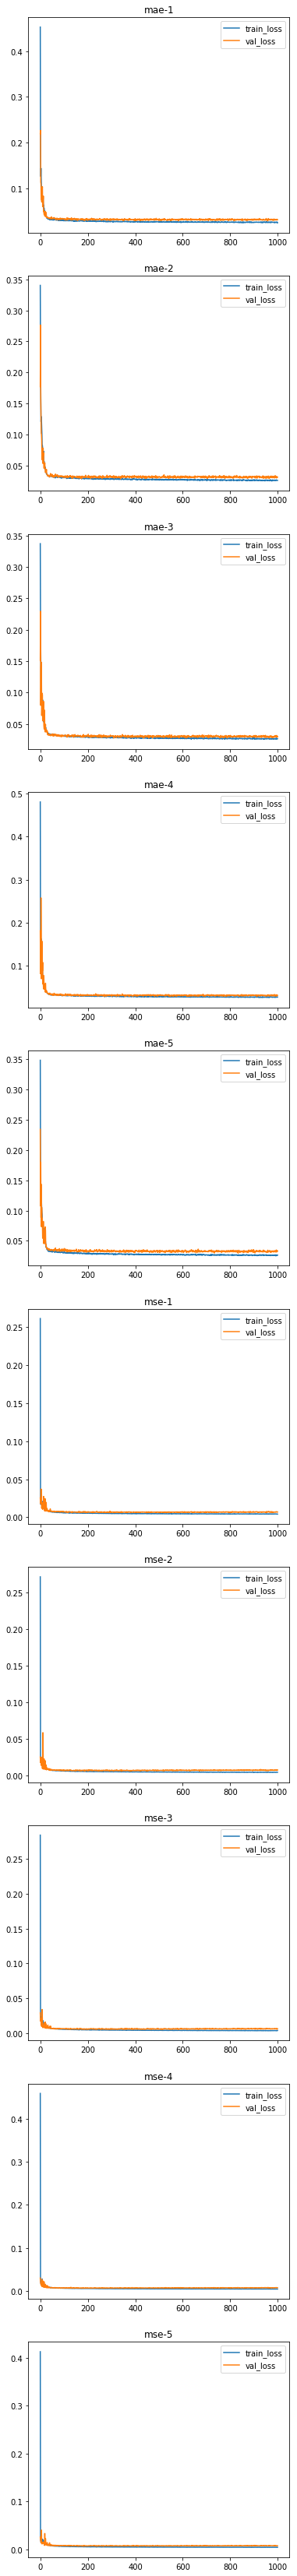

In [28]:
# plot training process
from matplotlib import pyplot as plt

fig, axes = plt.subplots(10,1,figsize=(6,60))

index = 0
for key in sorted(hists.keys()):
    axes[index].plot(hists[key].history['loss'], label='train_loss')
    #axes[index].plot(hists[key].history['RMSE'], label='train_rmse')
    #axes[index].plot(hists[key].history['R_SQUARE'], label='train_r2')
    axes[index].plot(hists[key].history['val_loss'], label='val_loss')
    #axes[index].plot(hists[key].history['val_RMSE'], label='val_rmse')
    #axes[index].plot(hists[key].history['val_R_SQUARE'], label='val_r2')
    axes[index].set_title(key)
    axes[index].legend()
    index +=1
    

plt.show()

## 4. Data Sequence Length Selection
In this section, Multiple MLP models with difference inputs are trained to verify that model performance can be improved by using temporal information.
- The MLP model with one hidden layer takes ultrasonic data as input and predicts angular velocity as control command to steer our robot. 
- For the input of model, we tried 1，16, 32，48 four different lengths of time-continuous ultrasonic data sequences， respectively.
- Considering the difference in input dimensions between models, the number of neurons of hidden layer is properly selected to achieve best performance for each model.
- To evluate the performance of difference models, mean absolute error and adjusted R-square sorce are used as evaluation metrics and 5-fold cross-validation is performed in all experiments.

Another two reasons of using MLP structure
- Selecting best data sequence length
- As baseline

The evaluation results on the validation dataset are not sufficient to demonstrate the feasibility of the model when appling it on a robot. Then we test our model performance in simulation experiments.
- The experiments results show that the MLP model structure cannot successfully drive the robot moving along the corridor environment.
- We suspect that the reason is that the MLP structure cannot perceive (is not aware of) the information of the spatial structure of the input data.

In [4]:
from keras.models import Model 
from keras.layers import Input, Dense
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import backend as K

from sklearn.model_selection import KFold
from datetime import datetime
import numpy as np

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true-y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/K.clip(SS_tot,K.epsilon(),None)

# assign customed_objects when loading model
dependencies = {'rmse': rmse, 'val_rmse': rmse, 
                'r_square': r_square, 'val_r_square': r_square}

data_path = "/media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/"
filename = "2019-07-03-"

model_path = "/home/ubuntu16/catkin_ws/src/sonar_navigation/h5/track-I-II/"

date_prefix = datetime.now().strftime('%Y_%m_%d')+'_'

batch_size = 128
dim = 1
lengths = [1, 16, 32, 48]
n_hiddens = [64, 128, 256, 512, 1024, 2048]

epochs = 5
seed = 7
np.random.seed(seed)

hists = {}


kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

for length in lengths:
    csv_path = data_path + filename + str(length) + '.csv'
    dataset = csv_read(csv_path, length)
    
    for n_hidden in n_hiddens:
        mse_fold = []
        rmse_fold = []
        mae_fold = []
        r2_fold = []
        count = 0
        # K-fold cross validation
        for train_index, valid_index in kfold.split(dataset):
            count +=1
        
            # loading dataset
            training_set   = np.array(dataset)[train_index]
            validation_set = np.array(dataset)[valid_index]
        
            train_generator = data_generator(training_set, batch_size, dim)
            valid_generator = data_generator(validation_set, batch_size, dim)
        
            train_steps_epoch = len(training_set)//batch_size
            valid_steps_epoch = len(validation_set)//batch_size
        
            # define model
            input_dim = length*16
            x = Input(shape=(input_dim, ))
            h1 = Dense(n_hidden, activation='relu')(x)
            y = Dense(1)(h1)
        
            model = Model(inputs=x, outputs=y)
        
            # compile model
            optimizer = optimizers.Adam(decay=1e-5)
            model.compile(loss='mse', 
                          optimizer=optimizer,
                          metrics=['mse', rmse, 'mae', r_square])
            if count == 1:
                model.summary()
    
            # save best model by monitoring val_RMSE
            model_name = model_path+ date_prefix +'mlp_'+str(length)+'_'+str(n_hidden)+'_'+str(count) +'.h5'
            model_checkpoint = ModelCheckpoint(model_name,
                                           monitor="val_r_square",
                                           save_best_only=True,
                                           mode='max')
    
            # fit model
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch = train_steps_epoch,
                                          epochs = epochs,
                                          validation_data = valid_generator,
                                          validation_steps = valid_steps_epoch,
                                          verbose = 0,
                                          callbacks=[model_checkpoint])
    
            # save training history and output epoch number of best model
            hists[str(length)+'_'+str(n_hidden)+'_'+str(count)] = history
        
            # evalute best model
            best_model = load_model(model_name, custom_objects=dependencies)
        
            val_loss, val_mse, val_rmse, val_mae, val_r2 = best_model.evaluate_generator(
                                                          valid_generator,
                                                          steps=valid_steps_epoch,
                                                          verbose = 0)
            
            print("==== LENGTH= {}, HIDDEN= {}, IN {} FOLD ====".format(length, n_hidden, count))
            print("EVALUATE BEST MODEL WITH MSE:")
            print("val_mse: {}".format(val_mse))
            print("val_rmse: {}".format(val_rmse))
            print("val_mae: {}".format(val_mae))
            print("val_r2: {}".format(val_r2))
        
            # save to list
            mse_fold.append(val_mse)
            rmse_fold.append(val_rmse)
            mae_fold.append(val_mae)
            r2_fold.append(val_r2)
    
        # output average rmse, R-square
        mse_ave  = np.mean(mse_fold)
        rmse_ave = np.mean(rmse_fold)
        mae_ave  = np.mean(mae_fold)
        r2_ave   = np.mean(r2_fold)
        
        print
        print("Final:: mse_ave: {}; rmse_ave: {}".format(mse_ave,rmse_ave))
        print("Final:: mae_ave: {}; r2_ave: {}".format(mae_ave,r2_ave))
        print
        print
        
        
# output all models' best metric values
n_models = len(lengths)*len(n_hiddens)

for i in range(n_models):
    val_mae_all, val_mse_all, val_rmse_all, val_r2_all = 0, 0, 0, 0
    val_mae_epochs, val_mse_epochs, val_rmse_epochs, val_r2_epochs = 0, 0, 0, 0
    for key in sorted(hists.keys())[i*5:(i+1)*5]:
        val_mae_best = min(hists[key].history['val_mean_absolute_error'])
        val_mse_best = min(hists[key].history['val_mean_squared_error'])
        val_rmse_best = min(hists[key].history['val_rmse'])
        val_r2_best   = max(hists[key].history['val_r_square'])
        
        val_mae_best_epoch = hists[key].history['val_mean_absolute_error'].index(val_mae_best) + 1
        val_mse_best_epoch = hists[key].history['val_mean_squared_error'].index(val_mse_best) + 1
        val_rmse_best_epoch = hists[key].history['val_rmse'].index(val_rmse_best) + 1
        val_r2_best_epoch   = hists[key].history['val_r_square'].index(val_r2_best) + 1
    
        val_mae_all += val_mae_best
        val_mse_all += val_mse_best
        val_rmse_all += val_rmse_best
        val_r2_all += val_r2_best
    
        val_mae_epochs += val_mae_best_epoch
        val_mse_epochs += val_mse_best_epoch
        val_rmse_epochs += val_rmse_best_epoch
        val_r2_epochs += val_r2_best_epoch
    
    print("======= {} ======".format(key))
    print("val_mse_best: {}, epoch: {}".format(val_mse_all/5.0, val_mse_epochs/5.0))
    print("val_rmse_best: {}, epoch: {}".format(val_rmse_all/5.0, val_rmse_epochs/5.0))
    print("val_mae_best: {}, epoch: {}".format(val_mae_all/5.0, val_mae_epochs/5.0))
    print("val_r2_best: {}, epoch: {}".format(val_r2_all/5.0, val_r2_epochs/5.0))

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-1.csv
The length of time sequence in this file is 1
Now 45422 data have been saved with custom data type
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 1, HIDDEN= 64, IN 1 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0135844011858
val_rmse: 0.11574927611
val_mae: 0.0691601752703
val_r2: 0.648484406301
_________________________________________

==== LENGTH= 1, HIDDEN= 128, IN 4 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0137471500518
val_rmse: 0.116444384626
val_mae: 0.0659250594143
val_r2: 0.653232023546
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 129       
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 1, HIDDEN= 128, IN 5 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0123460188042
val_rmse: 0.110045311813
val_mae: 0.0630682986762
val_r2: 0.689635459866
Final:: mse_ave: 0.0128347286928; rmse_ave: 0.112352659638
F

==== LENGTH= 1, HIDDEN= 512, IN 3 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0118233366271
val_rmse: 0.108157915409
val_mae: 0.0605884322098
val_r2: 0.678676537105
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 16)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               8704      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 513       
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 1, HIDDEN= 512, IN 4 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0114984129955
val_rmse: 0.106354981448
val_mae: 0.0603194668889
val_r2: 0.681297673498
____________________________________________________________

==== LENGTH= 16, HIDDEN= 64, IN 2 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0220745885079
val_rmse: 0.147995138275
val_mae: 0.108995817602
val_r2: 0.410127461808
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 65        
Total params: 16,513
Trainable params: 16,513
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 16, HIDDEN= 64, IN 3 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0166589076498
val_rmse: 0.128459648362
val_mae: 0.0900961108506
val_r2: 0.572049697808
___________________________________________________________

==== LENGTH= 16, HIDDEN= 256, IN 1 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0162430402956
val_rmse: 0.126772960063
val_mae: 0.0919010062303
val_r2: 0.599683486564
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 257       
Total params: 66,049
Trainable params: 66,049
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 16, HIDDEN= 256, IN 2 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0202618977188
val_rmse: 0.141832027371
val_mae: 0.112182720644
val_r2: 0.462532345738
_________________________________________________________

==== LENGTH= 16, HIDDEN= 512, IN 5 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0138131144789
val_rmse: 0.116776935969
val_mae: 0.0794899132103
val_r2: 0.62340759635
Final:: mse_ave: 0.0131127848662; rmse_ave: 0.113785442156
Final:: mae_ave: 0.078311232073; r2_ave: 0.647927595207


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 256)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dense_94 (Dense)             (None, 1)                 1025      
Total params: 264,193
Trainable params: 264,193
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 16, HIDDEN= 1024, IN 1 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0133890145325
val_rmse: 

==== LENGTH= 32, HIDDEN= 64, IN 4 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0174771988764
val_rmse: 0.131633466163
val_mae: 0.0952959023416
val_r2: 0.537882000208
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_111 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 65        
Total params: 32,897
Trainable params: 32,897
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 32, HIDDEN= 64, IN 5 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0221172678683
val_rmse: 0.148232179774
val_mae: 0.105662013165
val_r2: 0.442604240349
Final:: mse_ave: 0.0248306826396; rmse_ave: 0.156223915475


==== LENGTH= 32, HIDDEN= 256, IN 3 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0209108161075
val_rmse: 0.143604943263
val_mae: 0.101297669964
val_r2: 0.422993892431
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_129 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_130 (Dense)            (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 32, HIDDEN= 256, IN 4 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0175159794012
val_rmse: 0.131719555493
val_mae: 0.0935619955616
val_r2: 0.529342855726
_______________________________________________________

==== LENGTH= 32, HIDDEN= 1024, IN 2 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.014417273804
val_rmse: 0.119599624723
val_mae: 0.0831193802612
val_r2: 0.622437361309
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 1024)              525312    
_________________________________________________________________
dense_148 (Dense)            (None, 1)                 1025      
Total params: 526,337
Trainable params: 526,337
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 32, HIDDEN= 1024, IN 3 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0165526869441
val_rmse: 0.128173845581
val_mae: 0.0917019403407
val_r2: 0.536332386732
_____________________________________________________

==== LENGTH= 48, HIDDEN= 128, IN 1 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0272172716047
val_rmse: 0.164353239962
val_mae: 0.121664911189
val_r2: 0.265389035429
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_83 (InputLayer)        (None, 768)               0         
_________________________________________________________________
dense_165 (Dense)            (None, 128)               98432     
_________________________________________________________________
dense_166 (Dense)            (None, 1)                 129       
Total params: 98,561
Trainable params: 98,561
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 48, HIDDEN= 128, IN 2 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0272720996024
val_rmse: 0.164706353417
val_mae: 0.121369188598
val_r2: 0.290205164467
__________________________________________________________

==== LENGTH= 48, HIDDEN= 256, IN 5 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0245258712077
val_rmse: 0.156119992903
val_mae: 0.117748218243
val_r2: 0.389884843145
Final:: mse_ave: 0.0252693610399; rmse_ave: 0.158067607198
Final:: mae_ave: 0.117814980703; r2_ave: 0.34405728851


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_92 (InputLayer)        (None, 768)               0         
_________________________________________________________________
dense_183 (Dense)            (None, 512)               393728    
_________________________________________________________________
dense_184 (Dense)            (None, 1)                 513       
Total params: 394,241
Trainable params: 394,241
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 48, HIDDEN= 512, IN 1 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0232676985541
val_rmse: 0.

==== LENGTH= 48, HIDDEN= 1024, IN 4 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0181864229563
val_rmse: 0.134318601127
val_mae: 0.0965869488461
val_r2: 0.524983337947
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_101 (InputLayer)       (None, 768)               0         
_________________________________________________________________
dense_201 (Dense)            (None, 1024)              787456    
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 1025      
Total params: 788,481
Trainable params: 788,481
Non-trainable params: 0
_________________________________________________________________
==== LENGTH= 48, HIDDEN= 1024, IN 5 FOLD ====
EVALUATE BEST MODEL WITH MSE:
val_mse: 0.0182131062927
val_rmse: 0.134337899089
val_mae: 0.0987604025219
val_r2: 0.510316063677
Final:: mse_ave: 0.0177452682225; rmse_ave: 0.132622

KeyError: 'val_RMSE'

In [5]:
for i in range(n_models):
    val_mae_all, val_mse_all, val_rmse_all, val_r2_all = 0, 0, 0, 0
    val_mae_epochs, val_mse_epochs, val_rmse_epochs, val_r2_epochs = 0, 0, 0, 0
    for key in sorted(hists.keys())[i*5:(i+1)*5]:
        val_mae_best = min(hists[key].history['val_mean_absolute_error'])
        val_mse_best = min(hists[key].history['val_mean_squared_error'])
        val_rmse_best = min(hists[key].history['val_rmse'])
        val_r2_best   = max(hists[key].history['val_r_square'])
        
        val_mae_best_epoch = hists[key].history['val_mean_absolute_error'].index(val_mae_best) + 1
        val_mse_best_epoch = hists[key].history['val_mean_squared_error'].index(val_mse_best) + 1
        val_rmse_best_epoch = hists[key].history['val_rmse'].index(val_rmse_best) + 1
        val_r2_best_epoch   = hists[key].history['val_r_square'].index(val_r2_best) + 1
    
        val_mae_all += val_mae_best
        val_mse_all += val_mse_best
        val_rmse_all += val_rmse_best
        val_r2_all += val_r2_best
    
        val_mae_epochs += val_mae_best_epoch
        val_mse_epochs += val_mse_best_epoch
        val_rmse_epochs += val_rmse_best_epoch
        val_r2_epochs += val_r2_best_epoch
    
    print("======= {} ======".format(key))
    print("val_mse_best: {}, epoch: {}".format(val_mse_all/5.0, val_mse_epochs/5.0))
    print("val_rmse_best: {}, epoch: {}".format(val_rmse_all/5.0, val_rmse_epochs/5.0))
    print("val_mae_best: {}, epoch: {}".format(val_mae_all/5.0, val_mae_epochs/5.0))
    print("val_r2_best: {}, epoch: {}".format(val_r2_all/5.0, val_r2_epochs/5.0))

======= 16_1024_5 ======
val_mse_best: 0.0118676724564, epoch: 5.0
val_rmse_best: 0.108302955947, epoch: 5.0
val_mae_best: 0.0743651275869, epoch: 4.8
val_r2_best: 0.695606936727, epoch: 5.0
======= 16_128_5 ======
val_mse_best: 0.0188753482407, epoch: 4.8
val_rmse_best: 0.136441955843, epoch: 4.8
val_mae_best: 0.0975546103077, epoch: 4.8
val_r2_best: 0.501459904058, epoch: 4.8
======= 16_256_5 ======
val_mse_best: 0.016402489684, epoch: 4.8
val_rmse_best: 0.127214727657, epoch: 4.8
val_mae_best: 0.089874334644, epoch: 4.4
val_r2_best: 0.571751835687, epoch: 4.8
======= 16_512_5 ======
val_mse_best: 0.0129417280853, epoch: 4.2
val_rmse_best: 0.113076287018, epoch: 4.2
val_mae_best: 0.0780558585056, epoch: 4.2
val_r2_best: 0.661735264574, epoch: 4.2
======= 16_64_5 ======
val_mse_best: 0.0193091981911, epoch: 4.8
val_rmse_best: 0.137926252889, epoch: 4.8
val_mae_best: 0.097024273255, epoch: 4.8
val_r2_best: 0.494680748837, epoch: 4.8
======= 1_1024_5 ======
val_mse_best: 0.0110852226389

总结：
- 这种指定时序长度指定隐藏单元数量的实验没有任何意义，无法搜索出最优值！！要采用网格搜索的思想！！